In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
from tqdm import tqdm
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [12]:
# riproducibilità
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# percorso base e percorso dataset
base_dir = os.getcwd()
data_dir= os.path.join(base_dir, 'data_histo') # cartella contenente le immagini
# cartella di salvataggio
output_folder = os.path.join(base_dir, "pca_outputs")
os.makedirs(output_folder, exist_ok=True)  # crea se non esiste
plot_path = os.path.join(output_folder, "explained_variance_plot.png")

# configurazione
image_size = 224                 # dimensione a cui ridimensionare ogni immagine
train_ratio, val_ratio = 0.7, 0.15  # percentuali per suddividere in train/val/test

In [ ]:
# trasformazioni
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # ridimensiona le immagini
    transforms.ToTensor(),                        # converte in tensore
])

In [ ]:
# caricamento e split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)  # carica tutte le immagini con le etichette
total_size = len(full_dataset)                                           # numero totale di immagini
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size                           # il resto va al test set

# suddivisione casuale ma riproducibile
train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size],
                                            generator=torch.Generator().manual_seed(42))


In [ ]:
# estrazione e flattening
def extract_full_data(subset):
    data = []
    for i in tqdm(range(len(subset)), desc="Estrazione immagini"):
        image, _ = subset[i]              # estrae immagine (non serve etichetta)
        flat = image.view(-1)             # flatten dell'immagine [C x H x W] → [C*H*W]
        data.append(flat)
    return torch.stack(data).numpy()      # converte in array numpy per uso con sklearn

# estrazione dati
print("\nEstrazione immagini...")
train_data = extract_full_data(train_set)
val_data = extract_full_data(val_set)
test_data = extract_full_data(test_set)


Caricamento immagini...


Estrazione immagini: 100%|██████████| 2250/2250 [00:26<00:00, 85.93it/s]


In [ ]:
# standardizzazione tramite z-score
print("\nCalcolo normalizzazione globale con StandardScaler (z-score)...")
scaler = StandardScaler()  # calcola media e std su ciascuna feature (pixel)
scaler.fit(train_data)     # fit solo sui dati di train
train_data_std = scaler.transform(train_data)


Calcolo normalizzazione globale con StandardScaler (z-score)...


In [ ]:
# PCA
print("\nCalcolo PCA ...")
pca = PCA()   # PCA completa (non limitata a n_components)
pca.fit(train_data_std)  # fit sui dati standardizzati

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


Calcolo PCA completa...


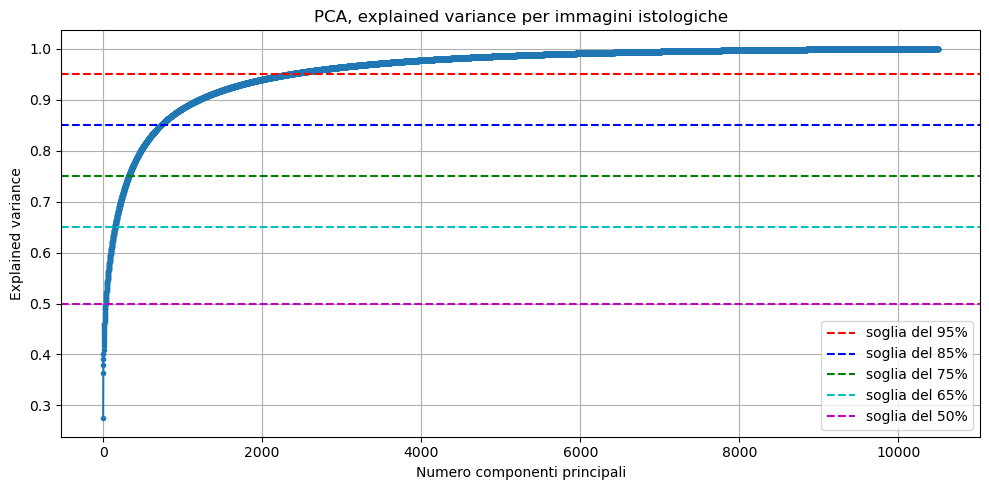

In [ ]:
# grafico explained variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='.')
# linee orizzontali per soglie visive
plt.axhline(y=0.95, color='r', linestyle='--', label='soglia del 95%')
plt.axhline(y=0.85, color='b', linestyle='--', label='soglia del 85%')
plt.axhline(y=0.75, color='g', linestyle='--', label='soglia del 75%')
plt.axhline(y=0.65, color='c', linestyle='--', label='soglia del 65%')
plt.axhline(y=0.50, color='m', linestyle='--', label='soglia del 50%')
# impostazioni grafiche
plt.xlabel('Numero componenti principali')
plt.ylabel('Explained variance')
plt.title('PCA, explained variance per immagini istologiche')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(plot_path)
plt.show()

print(f"Grafico salvato in: {plot_path}")

In [ ]:
# numero di componenti per ciascuna soglia scelta
soglie = [0.95, 0.85, 0.75, 0.65, 0.50]
for soglia in soglie:
    num_components = np.argmax(cumulative_variance >= soglia) + 1  # trova la prima componente cumulativa che supera la soglia
    print(f"Number of components that explains {int(soglia*100)}% of variance: {num_components}")

Number of components that explains 95% of variance: 2342
Number of components that explains 85% of variance: 725
Number of components that explains 75% of variance: 323
Number of components that explains 65% of variance: 150
Number of components that explains 50% of variance: 32
